In [10]:
import pandas as pd
import numpy as np
from gensim.models import HdpModel
from gensim import corpora
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score, roc_curve
from sklearn.svm import SVC
import matplotlib.pyplot as plt

# Hierarchical Dirichlet Process

The Hierarchical Dirichlet Process (HDP) is similar to the LDA model. The main difference is that rather than the number of topics being a parameter to the model, it is assumed to be a random variable whose distribution is determined by a Dirichlet process. This enables the model to learn the number of topics from the data, allowing you to skip the (slow) step of finding the optimal number of topics.

Note: the Dirichlet process is a probability distibution over the space of probability measures on a space $X$. It takes parameters $H$ (a probability measure, called the base distribution) and $\alpha$ (a positive real). It is defined by the property that if $G$ is Dirichlet process-distributed then for any finite partition $A_1, A_2, ..., A_n$ of $X$ the random variables $G_{|A_1}, G_{|A_2}, G_{|A_n}$ are collectively $Dirichlet({\alpha}H_{|A_1}, {\alpha}H_{|A_2}, ..., {\alpha}H_{|A_n})$. (where $Y_{|A}$ is the restriction of $Y$ to $A$)

Due to the similarity of the HDP and LDA, much of Mohammed's work in the previous section of the report is also applicable here (in particular, the model visualisation and the examining of individual topics). To avoid redundancy, I have refrained from reproducing this work here. Instead, I have focused on finding methods to improve the classification.

## Data Splitting

First we load in the data from a file, and compute the proportion which is spam (to be used later).

In [2]:
converter = lambda x: list(map(lambda y: y.strip("'"), x.strip("[]").split(", ")))
data = pd.read_csv('../data/data.csv', converters={"Email" : converter, "Lemmatized" : converter}, index_col=0)
spamproportion = sum(data.Spam) / len(data)

Now we split the data 5-fold. We will work with only one fold for now.

In [3]:
kf1 = KFold(n_splits=5, shuffle=True, random_state=12)
outerfolds = list(kf1.split(data))
train, test = outerfolds[0]
#train, test = train_test_split(data, test_size=0.2, random_state=12, stratify=data.Spam)

We now split the *training* set from our first fold into 10 further folds. We will train our model on each fold, and then make predictions on the test set using the model which performed best on its validation fold.

We are able to do this because, unlike the LDA topic model, the HDP infers the number of topics from the data. This means that we do not have to perform the computationally costly process of optimising the number of topics, and we can instead use the computation time to select a better model.

In [4]:
kf2 = KFold(n_splits=10, shuffle=True, random_state=47) # a specific random state is chosen for reproducibility only
innerfolds = list(kf2.split(train))

Here we define a few functions. The first simply takes the list of topic distributions produced by the topic model and outputs them in an array form, which is much more convenient to work with. The other two are much more interesting.

Using an HDP to classify emails into ham and spam presents a problem: the HDP assigns to each email a distribution over many (over 100) topics, and we must find a way to turn this distribution into a predicted class.

There are two approaches we could take here, and in fact we take both. The first option is to treat the output topic distribution as a feature vector, and use these as the input to a model-based classifier. The second way is to implement a simple non-model classifier which allows us to get predictions out of topic distributions without needing to train another model. Two such non-model classifiers are implemented here.

The first is very simple. It works like this:

* For each email, assign it to its modal topic (that is, the topic which the model assigns it the greatest probability of belonging to)
* For each topic, declare it to be a spam topic if the proportion of spam emails assigned to that topic exceeds a given threshold. This threshold is a parameter - in our case, we use the total proportion of spam emails in the dataset as the value (strictly speaking, we should really use the proportion of spam emails in the *training* set as our threshold instead - but the sample is large enough that these are approximately equal by the law of large numbers so this doesn't really matter).
* For each email, assign it a spam probability equal to the sum of the probabilities with which the model assigns it to each spam topic
* Declare an email to be spam if its spam probability exceeds some threshold (which is another parameter, taken by default to be 0.5)

This works reasonably well, but it has a couple of issues. The first is that topics are declared to be ham or spam based on a relatively small amount of the information carried by the distributions - just the modal topic for each email. The rest of the information in the distributions is used later, but this is too late to impact the topic labels. A second issue is that the binary labelling of topics as ham or spam is quite dubious a priori - it only makes sense if there's no topic overlap at all between ham and spam emails, which seems very unlikely. A third issue is that the method seems to be internally incoherent: we can have an email which is initally assigned to a spam topic, but is later declared to be not spam because the total probability that it lands in a spam topic is less than 0.5.

The second non-model classifier resolves these issues. It works like this:

* For each topic, compute the sum of the probabilities that an email belongs to this topic across all spam emails. Then, compute this same sum across all email (both ham and spam). Assign to the topic a weight equal to the ratio of these two qualities (this measures 'how spammy' this topic is).
* For each email $e$, compute the sum $\sum_{T{\in}Topics}{{p_{e,T}}w_T}$ where $p_{e,T}$ is the probability the model assigned to $e$ belonging to topic $T$, and $w_T$ is the weight assigned to topic $T$ earlier. In other words, this is the dot product of the topic distribution of $e$ with the vector of topic weights.
 * Let the spam probability of $e$ be this sum.
* Declare an email to be spam if its spam probability exceeds some threshold (a parameter, taken by default to be 0.5)

Both of these non-model classifiers have been implemented here as higher-order functions - the functions given here do not perform the classification themselves, but rather construct an ordinary function which performs the classification.

In [6]:
def distarray(dist, numtopics):
    array = np.zeros((len(dist), numtopics))
    for i in range(len(dist)):
        for pair in dist[i]:
            topic, prob = pair
            array[i, topic] = prob
    return array

def simple_classifier(train, truth, threshold=0.5): # Takes a training dataset and ground truth, and returns a function to get spam probabilities from test data
    numtopics = len(train[0])
    numemails = len(train)
    spamcount = np.zeros(numtopics)
    emailcount = np.zeros(numtopics)
    spamtopic = np.zeros(numtopics)
    for i in range(numemails):
        email = train[i]
        topic = np.argmax(email)
        emailcount[topic] += 1
        if truth[i]:
            spamcount[topic] +=1
    for j in range(numtopics):
        if (emailcount[j] * threshold) < spamcount[j]:
            spamtopic[j] = 1
    return (lambda x: np.dot(x, spamtopic))

def simple_classifier2(train, truth):
    numtopics = len(train[0])
    topicweight = np.zeros(numtopics)
    for i in range(numtopics):
        topic = train[:, i]
        totalprob = sum(topic)
        spamprob = np.dot(topic, truth)
        if totalprob == 0:
            topicweight[i] = 0
        else:
            topicweight[i] = spamprob / totalprob
    return (lambda x: np.dot(x, topicweight))

Now we train our topic models. For each topic model that we train, we use both of the non-model classifiers and also a SVM and a Random Forest. For each of the four classifiers, we take the topic model which performed best on its verification set when paired with that classifier and plot ROC curves so that we can compare their performance. We won't pay too much attention to these, though - this only shows performance on the verification set, and what we really care about is performance on the *test* set.

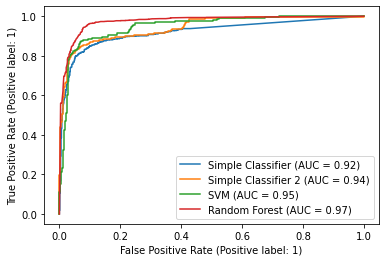

In [7]:
bestauc_nc = 0
bestauc_uc = 0
bestauc_svm = 0
bestauc_rf = 0
topic_models = []
dictionaries = []
nc_classifiers = []
uc_classifiers = []
svm_classifiers = []
rf_classifiers = []

i = 0
traindata = data.loc[train]
traindata.reset_index(drop=True, inplace=True)
for fold in innerfolds:
    innertrain, verify = fold
    innertraindata = traindata.loc[innertrain]
    testdata = traindata.loc[verify]
    dictionary = corpora.Dictionary(innertraindata.Lemmatized)
    dictionary.filter_extremes(no_below=15, no_above=0.5)
    dictionaries.append(dictionary)
    traincorpus = list(map(dictionary.doc2bow, innertraindata.Lemmatized))
    testcorpus = list(map(dictionary.doc2bow, testdata.Lemmatized))
    hdp = HdpModel(traincorpus, dictionary, random_state=63)
    topic_models.append(hdp)
    traindist = list(hdp[traincorpus])
    testdist = list(hdp[testcorpus])
    numtopics = len(hdp.get_topics())
    trainarray = distarray(traindist, numtopics)
    testarray = distarray(testdist, numtopics)
    trueresults = list(testdata.Spam)
    
    nc = simple_classifier(trainarray, list(innertraindata.Spam), threshold=spamproportion)
    nc_classifiers.append(nc)
    spamprobs = list(map(nc, testarray))
    #testresults = list(map(lambda x: x > 0.5, spamprobs))
    auc = roc_auc_score(trueresults, spamprobs)
    if auc > bestauc_nc:
        bestauc_nc = auc
        bestmodel_nc = hdp
        classifier_nc = nc
        bestsplit_nc = i
        true_nc = trueresults
        test_nc = spamprobs
        dict_nc = dictionary
        
    uc = simple_classifier2(trainarray, list(innertraindata.Spam))
    uc_classifiers.append(uc)
    spamprobs = list(map(uc, testarray))
    #testresults = list(map(lambda x: x > 0.5, spamprobs))
    auc = roc_auc_score(trueresults, spamprobs)
    if auc > bestauc_uc:
        bestauc_uc = auc
        bestmodel_uc = hdp
        classifier_uc = uc
        bestsplit_uc = i
        true_uc = trueresults
        test_uc = spamprobs
        dict_uc = dictionary
        
    svm = SVC(random_state=63)
    svm = svm.fit(trainarray, innertraindata.Spam)
    svm_classifiers.append(svm)
    spamscores = svm.decision_function(testarray)
    #testresults = list(map(lambda x: x > 0.5, spamprobs))
    auc = roc_auc_score(trueresults, spamscores)
    if auc > bestauc_svm:
        bestauc_svm = auc
        bestmodel_svm = hdp
        classifier_svm = svm
        bestsplit_svm = i
        true_svm = trueresults
        test_svm = spamscores
        dict_svm = dictionary
        
    rf = RandomForestClassifier(random_state=63)
    rf = rf.fit(trainarray, innertraindata.Spam)
    rf_classifiers.append(rf)
    spamprobs = list(map(lambda x: x[1], rf.predict_proba(testarray)))
    #testresults = list(map(lambda x: x > 0.5, spamprobs))
    auc = roc_auc_score(trueresults, spamprobs)
    if auc > bestauc_rf:
        bestauc_rf = auc
        bestmodel_rf = hdp
        classifier_rf = rf
        bestsplit_rf = i
        true_rf = trueresults
        test_rf = spamprobs
        dict_rf = dictionary
        
    i += 1

ax = plt.gca()
RocCurveDisplay.from_predictions(true_nc, test_nc, ax=ax, name="Simple Classifier")
RocCurveDisplay.from_predictions(true_uc, test_uc, ax=ax, name="Simple Classifier 2")
RocCurveDisplay.from_predictions(true_svm, test_svm, ax=ax, name="SVM")
RocCurveDisplay.from_predictions(true_rf, test_rf, ax=ax, name="Random Forest")

We see that the first non-model classifier performs the worst, the second non-model classifier performs quite a bit better, the SVM performs slightly better still and the Random Forest performs best of all.

In [63]:
numtopics

150

We see that the HDP has inferred the existence of 150 different topics - three times as many as our LDA model was tested with!

We now test the best topic model-classifier pair for each classifier on the reserved test dataset from earlier:

## Simple Classifier

In [9]:
testdata = data.loc[outerfolds[0][1]]
corpus = list(map(dict_nc.doc2bow, testdata.Lemmatized))
dist = list(bestmodel_nc[corpus])
numtopics = len(bestmodel_nc.get_topics())
array = distarray(dist, numtopics)
trueresults = list(testdata.Spam)

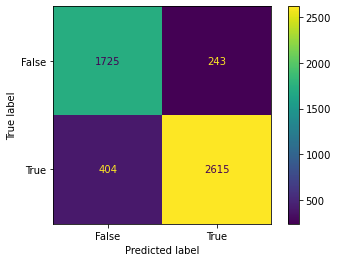

In [25]:
spamprobs = list(map(classifier_nc, array))
nc_roc = roc_curve(trueresults, spamprobs)
nc_score = roc_auc_score(trueresults, spamprobs)
nc_results = list(map(lambda x: x > 0.5, spamprobs))
ConfusionMatrixDisplay.from_predictions(trueresults, nc_results)

## Simple Classifier 2

In [15]:
testdata = data.loc[outerfolds[0][1]]
corpus = list(map(dict_uc.doc2bow, testdata.Lemmatized))
dist = list(bestmodel_uc[corpus])
numtopics = len(bestmodel_uc.get_topics())
array = distarray(dist, numtopics)
trueresults = list(testdata.Spam)

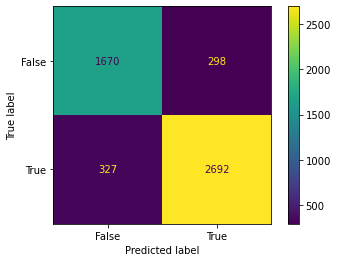

In [26]:
spamprobs = list(map(classifier_uc, array))
uc_roc = roc_curve(trueresults, spamprobs)
uc_score = roc_auc_score(trueresults, spamprobs)
uc_results = list(map(lambda x: x > 0.5, spamprobs))
ConfusionMatrixDisplay.from_predictions(trueresults, uc_results)

## SVM

In [17]:
testdata = data.loc[outerfolds[0][1]]
corpus = list(map(dict_svm.doc2bow, testdata.Lemmatized))
dist = list(bestmodel_svm[corpus])
numtopics = len(bestmodel_svm.get_topics())
array = distarray(dist, numtopics)
trueresults = list(testdata.Spam)

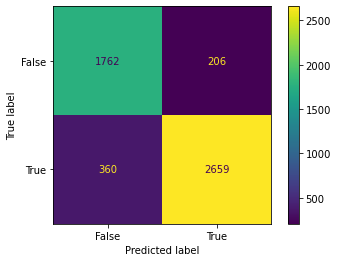

In [27]:
spamscores = classifier_svm.decision_function(array)
svm_roc = roc_curve(trueresults, spamscores)
svm_score = roc_auc_score(trueresults, spamscores)
svm_results = list(map(lambda x: x > 0, spamscores))
ConfusionMatrixDisplay.from_predictions(trueresults, svm_results)

## Random Forest

In [21]:
testdata = data.loc[outerfolds[0][1]]
corpus = list(map(dict_uc.doc2bow, testdata.Lemmatized))
dist = list(bestmodel_uc[corpus])
numtopics = len(bestmodel_uc.get_topics())
array = distarray(dist, numtopics)
trueresults = list(testdata.Spam)

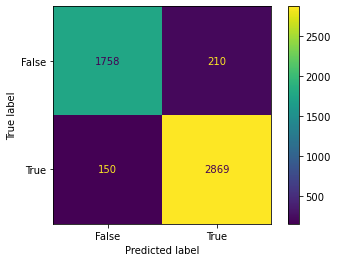

In [28]:
spamprobs = list(map(lambda x: x[1], classifier_rf.predict_proba(array)))
rf_roc = roc_curve(trueresults, spamprobs)
rf_score = roc_auc_score(trueresults, spamprobs)
rf_results = list(map(lambda x: x > 0.5, spamprobs))
ConfusionMatrixDisplay.from_predictions(trueresults, rf_results)

In [23]:
np.save('.\data\HDP_Simple_Best', nc_roc)
np.save('.\data\HDP_Improved_Best', uc_roc)
np.save('.\data\HDP_SVM_Best', svm_roc)
np.save('.\data\HDP_RF_Best', rf_roc)

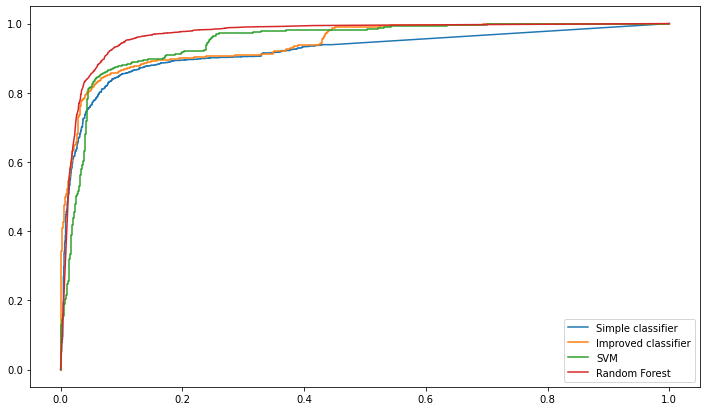

In [24]:
plt.subplots(figsize=(12,7))
plt.plot(nc_roc[0], nc_roc[1], label="Simple classifier")
plt.plot(uc_roc[0], uc_roc[1], label="Improved classifier")
plt.plot(svm_roc[0], svm_roc[1], label="SVM")
plt.plot(rf_roc[0], rf_roc[1], label="Random Forest")

plt.legend()

In [31]:
print("Simple classifier AUC:", nc_score)
print("Simple classifier 2 AUC:", uc_score)
print("SVM AUC:", svm_score)
print("Random Forest AUC:", rf_score)

Simple classifier AUC: 0.9191643978380825
Simple classifier 2 AUC: 0.9414938452133775
SVM AUC: 0.9451492175570978
Random Forest AUC: 0.9686484244769575


From the confusion matrices, we see that at the default thresholds all of the classifiers perform reasonably well. Both non-model classifiers perform about as well as each other, while the SVM performs slightly better and the Random Forest performs better still. However, by the metric of AUC we see that the improved non-model classifier performs almost as well as SVM, though the Random Forest beats both by a significant margin.

The shapes of the ROC curves are also quite interesting - the curves for the improved non-model classifier and the SVM exhibit a spike in recall once the proportion of false positives exceeds a certain value. This may indicate that there is a cluster of spam emails which is missed before this point, but is all caught at once when the threshold is made loose enough.

# Voting Models

During the cross-validation phase, we trained 10 different topic models. Previously we just took the one which performed the best on its validation set (when paired with a given classifier) and used that as our final model, but this is not the only approach we can take. Another option is to instead try to combine the 10 topic model-classifier pairs into a single, better, classifier. One way to do this is with *voting* - we have all 10 models make predictions for each email, and declare it to be spam if more than a given threshold (taken here to be 6) of the voting models declare it to be spam. 

In [32]:
num_emails = len(testdata)
probarray_nc = np.zeros((num_emails, 10))
probarray_uc = np.zeros((num_emails, 10))
scorearray_svm = np.zeros((num_emails, 10))
probarray_rf = np.zeros((num_emails, 10))

for i in range(10):
    corpus = list(map(dictionaries[i].doc2bow, testdata.Lemmatized))
    dist = list(topic_models[i][corpus])
    numtopics = len(topic_models[i].get_topics())
    array = distarray(dist, numtopics)
    probarray_nc[:, i] = list(map(nc_classifiers[i], array))
    probarray_uc[:, i] = list(map(uc_classifiers[i], array))
    scorearray_svm[:, i] = svm_classifiers[i].decision_function(array)
    probarray_rf[:, i] = list(map(lambda x: x[1], rf_classifiers[i].predict_proba(array)))

In [39]:
vote_threshold = 6 # number of spam votes needed to declare an email to be spam

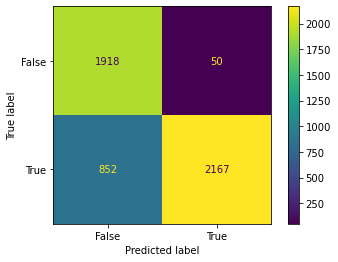

In [41]:
sortarray = probarray_nc
spamprobs = np.zeros(num_emails)
for i in range(num_emails):
    sortarray[i] = np.sort(sortarray[i])
    spamprobs[i] = sortarray[i, 10 - vote_threshold]

trueresults = list(testdata.Spam)
nc_voting_roc = roc_curve(trueresults, spamprobs)
nc_voting_score = roc_auc_score(trueresults, spamprobs)
ncresults = list(map(lambda x: x > 0.5, spamprobs))
ConfusionMatrixDisplay.from_predictions(trueresults, ncresults)

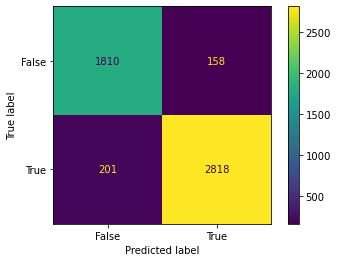

In [42]:
sortarray = probarray_uc
spamprobs = np.zeros(num_emails)
for i in range(num_emails):
    sortarray[i] = np.sort(sortarray[i])
    spamprobs[i] = sortarray[i, 10 - vote_threshold]

trueresults = list(testdata.Spam)
uc_voting_roc = roc_curve(trueresults, spamprobs)
uc_voting_score = roc_auc_score(trueresults, spamprobs)
ucresults = list(map(lambda x: x > 0.5, spamprobs))
ConfusionMatrixDisplay.from_predictions(trueresults, ucresults)

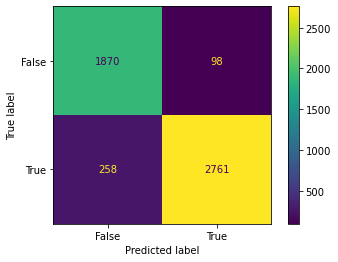

In [43]:
sortarray = scorearray_svm
spamscores = np.zeros(num_emails)
for i in range(num_emails):
    sortarray[i] = np.sort(sortarray[i])
    spamscores[i] = sortarray[i, 10 - vote_threshold]

trueresults = list(testdata.Spam)
svm_voting_roc = roc_curve(trueresults, spamscores)
svm_voting_score = roc_auc_score(trueresults, spamscores)
svmresults = list(map(lambda x: x > 0, spamscores))
ConfusionMatrixDisplay.from_predictions(trueresults, svmresults)

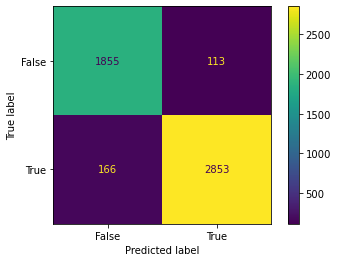

In [44]:
sortarray = probarray_rf
spamprobs = np.zeros(num_emails)
for i in range(num_emails):
    sortarray[i] = np.sort(sortarray[i])
    spamprobs[i] = sortarray[i, 10 - vote_threshold]

trueresults = list(testdata.Spam)
rf_voting_roc = roc_curve(trueresults, spamprobs)
rf_voting_score = roc_auc_score(trueresults, spamprobs)
rfresults = list(map(lambda x: x > 0.5, spamprobs))
ConfusionMatrixDisplay.from_predictions(trueresults, rfresults)

In [45]:
np.save('.\data\HDP_Simple_Vote', nc_voting_roc)
np.save('.\data\HDP_Improved_Vote', uc_voting_roc)
np.save('.\data\HDP_SVM_Vote', svm_voting_roc)
np.save('.\data\HDP_RF_Vote', rf_voting_roc)

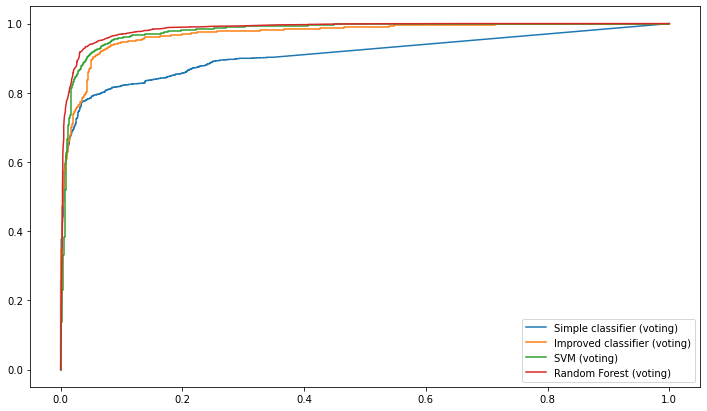

In [47]:
plt.subplots(figsize=(12,7))
plt.plot(nc_voting_roc[0], nc_voting_roc[1], label="Simple classifier (voting)")
plt.plot(uc_voting_roc[0], uc_voting_roc[1], label="Improved classifier (voting)")
plt.plot(svm_voting_roc[0], svm_voting_roc[1], label="SVM (voting)")
plt.plot(rf_voting_roc[0], rf_voting_roc[1], label="Random Forest (voting)")

plt.legend()

In [48]:
print("Simple classifier AUC:", nc_voting_score)
print("Simple classifier 2 AUC:", uc_voting_score)
print("SVM AUC:", svm_voting_score)
print("Random Forest AUC:", rf_voting_score)

Simple classifier AUC: 0.9101113005167812
Simple classifier 2 AUC: 0.9705080896867266
SVM AUC: 0.978445960138634
Random Forest AUC: 0.9856247492170185


For the most part, this significantly improves the model - both at the default threshold (from the confusion matrix) and overall (from the ROC curve and AUC scores). Interestingly, the unusual hump in the ROC curves for the improved non-model classifier and the SVM classifier have disappeared (presumably the cluster/s of spam behind these humps do not evade detection at such low thresholds anymoe).

However, this has a quite strange effect on the simpler non-model classifier - at the default threshold, it vastly increases the number of false negatives and decreases the number of false positives, though I do not know why this is. It also actually *decreases* the AUC score of this version of the model compared to just taking the single best model.

# Average Models

Voting is not the only way in which we can combine our models. Another option is to use the average prediction (either the spam probability or spam score, depending on the classifier) of the 10 constituent models to get our final prediction.

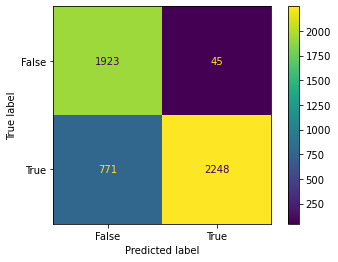

In [54]:
meanprobs = np.mean(probarray_nc, 1)
nc_average_roc = roc_curve(trueresults, meanprobs)
nc_average_score = roc_auc_score(trueresults, meanprobs)
ncresults = list(map(lambda x: x > 0.5, meanprobs))
ConfusionMatrixDisplay.from_predictions(trueresults, ncresults)

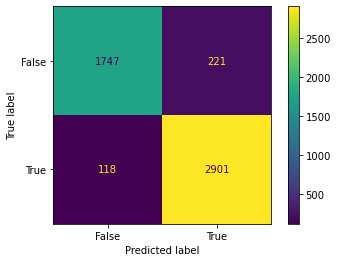

In [55]:
meanprobs = np.mean(probarray_uc, 1)
uc_average_roc = roc_curve(trueresults, meanprobs)
uc_average_score = roc_auc_score(trueresults, meanprobs)
ucresults = list(map(lambda x: x > 0.5, meanprobs))
ConfusionMatrixDisplay.from_predictions(trueresults, ucresults)

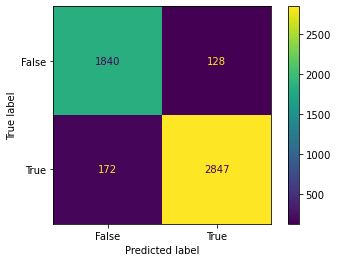

In [57]:
meanscore = np.mean(scorearray_svm, 1)
svm_average_roc = roc_curve(trueresults, meanscore)
svm_average_score = roc_auc_score(trueresults, meanscore)
svmresults = list(map(lambda x: x > 0, meanscore))
ConfusionMatrixDisplay.from_predictions(trueresults, svmresults)

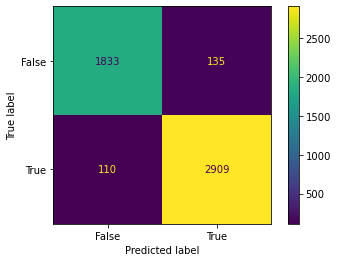

In [58]:
meanprobs = np.mean(probarray_rf, 1)
rf_average_roc = roc_curve(trueresults, meanprobs)
rf_average_score = roc_auc_score(trueresults, meanprobs)
rfresults = list(map(lambda x: x > 0.5, meanprobs))
ConfusionMatrixDisplay.from_predictions(trueresults, rfresults)

In [59]:
np.save('.\data\HDP_Simple_Mean', nc_average_roc)
np.save('.\data\HDP_Improved_Mean', uc_average_roc)
np.save('.\data\HDP_SVM_Mean', svm_average_roc)
np.save('.\data\HDP_RF_Mean', rf_average_roc)

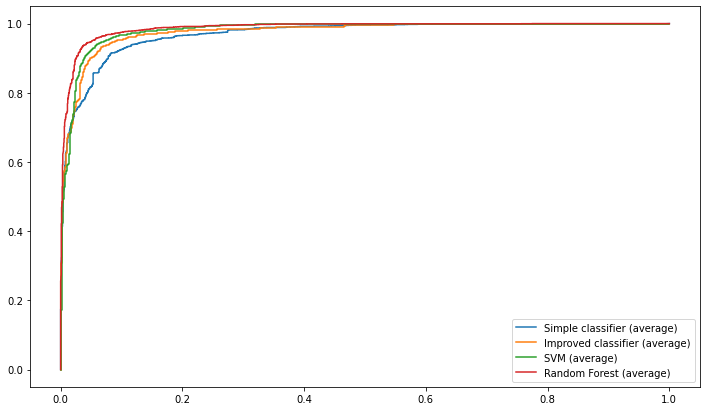

In [60]:
plt.subplots(figsize=(12,7))
plt.plot(nc_average_roc[0], nc_average_roc[1], label="Simple classifier (average)")
plt.plot(uc_average_roc[0], uc_average_roc[1], label="Improved classifier (average)")
plt.plot(svm_average_roc[0], svm_average_roc[1], label="SVM (average)")
plt.plot(rf_average_roc[0], rf_average_roc[1], label="Random Forest (average)")

plt.legend()

In [61]:
print("Simple classifier AUC:", nc_average_score)
print("Simple classifier 2 AUC:", uc_average_score)
print("SVM AUC:", svm_average_score)
print("Random Forest AUC:", rf_average_score)

Simple classifier AUC: 0.9691452777396273
Simple classifier 2 AUC: 0.9755752523987646
SVM AUC: 0.9809739872407006
Random Forest AUC: 0.9872592146756182


This performs even better than the voting model, though not by much (and the distribution of the two types of error has changed). This is perhaps unsurprising, since it makes use of more of the information provided by the 10 models than simply voting does (it cares much more about *strength of belief*). The same unusual behaviour is observed with the simpler non-model classifier at the default threshold, but unlike in the previous case it seems like this time the issue can be resolved (and a good classifier can be produced) simply by changing the threshold - as we can see that the ROC curve is much better this time, with the AUC being only slightly worse than the rest of the classifiers.

I had originally intended to redo all of these calculations for the other four folds and take the average AUC scores, but this turned out to be too computationally intensive. The blocks below are left here for completeness' sake, but I strongly suggest *not* running them.

In [8]:
topic_models_cross = [topic_models, [], [], [], []]
dictionaries_cross = [dictionaries, [], [], [], []]
nc_classifiers_cross = [nc_classifiers, [], [], [], []]
uc_classifiers_cross = [uc_classifiers, [], [], [], []]
svm_classifiers_cross = [svm_classifiers, [], [], [], []]
rf_classifiers_cross = [rf_classifiers, [], [], [], []]
bestsplits_nc = [bestsplit_nc, None, None, None, None]
bestsplits_uc = [bestsplit_uc, None, None, None, None]
bestsplits_svm = [bestsplit_svm, None, None, None, None]
bestsplits_rf = [bestsplit_rf, None, None, None, None]

for i in range(1, 5):
    train, test = outerfolds[i]
    innerfolds = kf2.split(train)
    
    bestauc_nc = 0
    bestauc_uc = 0
    bestauc_svm = 0
    bestauc_rf = 0
    
    traindata = data.loc[train]
    traindata.reset_index(drop=True, inplace=True)
    j = 0
    for fold in innerfolds:

        innertrain, verify = fold
        innertraindata = traindata.loc[innertrain]
        testdata = traindata.loc[verify]
        dictionary = corpora.Dictionary(innertraindata.Lemmatized)
        dictionary.filter_extremes(no_below=15, no_above=0.5)
        dictionaries_cross[i].append(dictionary)
        traincorpus = list(map(dictionary.doc2bow, innertraindata.Lemmatized))
        testcorpus = list(map(dictionary.doc2bow, testdata.Lemmatized))
        hdp = HdpModel(traincorpus, dictionary, random_state=63)
        topic_models_cross[i].append(hdp)
        traindist = list(hdp[traincorpus])
        testdist = list(hdp[testcorpus])
        numtopics = len(hdp.get_topics())
        trainarray = distarray(traindist, numtopics)
        testarray = distarray(testdist, numtopics)
        trueresults = list(testdata.Spam)
    
        nc = naive_classifier(trainarray, list(innertraindata.Spam), threshold=spamproportion)
        nc_classifiers_cross[i].append(nc)
        spamprobs = list(map(nc, testarray))
        #testresults = list(map(lambda x: x > 0.5, spamprobs))
        auc = roc_auc_score(trueresults, spamprobs)
        if auc > bestauc_nc:
            bestauc_nc = auc
            bestsplits_nc[i] = j
        
        uc = upgraded_classifier(trainarray, list(innertraindata.Spam))
        uc_classifiers_cross[i].append(uc)
        spamprobs = list(map(uc, testarray))
        #testresults = list(map(lambda x: x > 0.5, spamprobs))
        auc = roc_auc_score(trueresults, spamprobs)
        if auc > bestauc_uc:
            bestauc_uc = auc
            bestsplits_uc[i] = j

        svm = SVC(random_state=63)
        svm = svm.fit(trainarray, innertraindata.Spam)
        svm_classifiers_cross[i].append(svm)
        spamscores = svm.decision_function(testarray)
        #testresults = list(map(lambda x: x > 0.5, spamprobs))
        auc = roc_auc_score(trueresults, spamscores)
        if auc > bestauc_svm:
            bestauc_svm = auc
            bestsplits_svm[i] = j
        
        rf = RandomForestClassifier(random_state=63)
        rf = rf.fit(trainarray, innertraindata.Spam)
        rf_classifiers_cross[i].append(rf)
        spamprobs = list(map(lambda x: x[1], rf.predict_proba(testarray)))
        #testresults = list(map(lambda x: x > 0.5, spamprobs))
        auc = roc_auc_score(trueresults, spamprobs)
        if auc > bestauc_rf:
            bestauc_rf = auc
            bestsplits_rf[i] = j

        j += 1

In [ ]:
fold_num = 4

testdata = data.loc[outerfolds[fold_num][1]]
corpus = list(map(dictionaries_cross[fold_num][bestsplits_rf[fold_num]].doc2bow, testdata.Lemmatized))
dist = list(topic_models_cross[fold_num][bestsplits_rf[fold_num]][corpus])
numtopics = len(topic_models_cross[fold_num][bestsplits_rf[fold_num]].get_topics())
array = distarray(dist, numtopics)
trueresults = list(testdata.Spam)

In [ ]:
spamprobs = list(map(lambda x: x[1], rf_classifiers_cross[fold_num][bestsplits_rf[fold_num]].predict_proba(array)))
RocCurveDisplay.from_predictions(trueresults, spamprobs)
rf_results = list(map(lambda x: x > 0.5, spamprobs))
ConfusionMatrixDisplay.from_predictions(trueresults, rf_results)